In [1]:
#select where to run this notebook---
binder_or_localpc=True #True: if you want to run the script using binder or in your local PC
google_colab=False #True: if you want to run the script in google colab

In [2]:
%%capture
#!pip freeze. #to list the packages installed in colab
#or install without checking above (!but do it just once)---
if google_colab:
    !pip install numpy
    !pip install matplotlib
    !pip install xarray
    !pip install cartopy
    !pip install shapely --upgrade --force-reinstall --no-binary shapely #https://github.com/SciTools/cartopy/issues/871

In [3]:
#install below packages in case you don't have them---
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
from datetime import datetime
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing #for drawing a square 

In [4]:
#modify the local path in case you run this script in your computer---
if binder_or_localpc:
    main_dir="../"
if google_colab:
    #google colab path:
    mount_point='/content/gdrive/' #dir name for a temporal mount point (just for running this script)
    gdrive_path="MyDrive/colab_repos/" #the path in "my Google Drive" where you have cloned the repo
    main_dir=mount_point+gdrive_path
    #mount:
    from google.colab import drive
    drive.mount(mount_point)

In [5]:
#don't modify below names---
#AGU number:
agu_number="num" #put here the agu manuscript number
#name of the repository:
if binder_or_localpc: 
    dir_repo_name=""
if google_colab:
    #name of directories from the cloned github repo:
    dir_repo_name="paper_Atmospherically_Driven_Seasonal_Interannual_LTTS_MultipleInlet/"
dir_data="data/"
dir_functions="functions/"
dir_wavelet_functions="pycwt_wavelet_package/"
dir_figures="figures/"
#name of file with data:
file_ncep_ncar_monthly_pcs="ncep_ncar_monthly_eofs_pcs_nao_eap_scan_from_detrend_deseasonalized_mslp.nc"

In [6]:
#wavelet functions----
#- we are using functions from the package pycwt (https://anaconda.org/conda-forge/pycwt)
#- we have only used some functions of the above package and added our own ones to perform bias correction for the power spectrum (Liu et al., 2007)
#wavelet path:
sys.path.append(f'{main_dir}{dir_repo_name}{dir_functions}{dir_wavelet_functions}')
#functions from pycwt package---
from mothers import Morlet
from helpers import ar1
#our functions---
#inside them we use functions from pycwt
import get_results as gr

In [7]:
#create dir figures if it does not exists---
if not os.path.exists(main_dir+dir_repo_name+dir_figures):
    os.makedirs(main_dir+dir_repo_name+dir_figures)

In [8]:
glob_font_size=9
params = {'legend.fontsize':glob_font_size,
          'axes.titlesize':glob_font_size+1,'axes.labelsize': glob_font_size, #size of titles, x-y labels 
          'xtick.labelsize':glob_font_size,'ytick.labelsize':glob_font_size, #size of xtick-labels, ytick-labels
          'xtick.major.size':2,'xtick.major.width':.8, #length and width of xticks marks
          'ytick.major.size':2,'ytick.major.width':.8,} #length and width of yticks marks
mpl.rcParams.update(params)

In [9]:
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

In [10]:
#open data---
ds=xr.open_dataset(main_dir+dir_repo_name+dir_data+file_ncep_ncar_monthly_pcs)
ds

<xarray.Dataset>
Dimensions:      (time: 792, mode: 3, lat: 21, lon: 53)
Coordinates:
  * time         (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2015-12-01
  * mode         (mode) int64 0 1 2
  * lat          (lat) float32 30.0 32.5 35.0 37.5 40.0 ... 72.5 75.0 77.5 80.0
  * lon          (lon) float32 -80.0 -77.5 -75.0 -72.5 ... 42.5 45.0 47.5 50.0
Data variables:
    pc           (time, mode) float64 ...
    eof          (mode, lat, lon) float64 ...
    var_exp      (mode) float64 ...
    ug_from_eof  (mode, lat, lon) float64 ...
    vg_from_eof  (mode, lat, lon) float64 ...
Attributes:
    general_info:  1) Analysis from monthly ncep-ncar 1950-2015. 2) Data was ...
    mode:          0=NAO, 1=EAP, 2=SCAN

In [11]:
lon=ds.lon.values; lat=ds.lat.values
xx,yy=np.meshgrid(lon,lat)
iyy=2;ixx=2

In [12]:
########################################################
def wavelets(data,dim="time",standardization=True,filter_type="low-pass",cutoff_periods=[0.5*365],printing=False,var_label=None):
    """
    - Perform waveles using functions from pycwt package

    Parameters
    ----------
    - data: xr.core.dataarray.DataArray
            Time series of the spatially-averaged 15-day mean "Tr" or "Te", or the 15-day mean "wind energy".
            This is the data used as input for the wavelet function.
    - dim: str
           Dimension used to perform the wavelet. Default="time"
    - standardization: bool
                      True = standardized input data for wavelets.
                      False = use original data for wavelets.
    - filter_type: str
                   Type of wavelet filter to perform. 
                   "low-pass" or "high-pass" or "band-pass".
    - cutoff_periods: list
                      List used to draw cut-off periods of data filter with wavelets.
                      [ref_period] = for low-pass or high-pass filters.
                      [period1, period2] = for band-pass filter.
    - printint: bool
                For printing statistics from the wavelet analysis.
    - var_label: str 
                 String of any random name assigned to the variable employed for wavelet

    Returns
    -------
    - waveler_result: dictionary
                      dictionary with variables related to output of wavelet function.
        freq : array like
            Vector of Fourier frequencies (1 / time units) that
            corresponds to the wavelet scales.
        period : array like
            Vector of Fourier periods (1 / freq).
        scale : numpy.ndarray
            Vector of scale indices given by sj = s0 * 2**(j * dj),
            j={0, 1, ..., J}. 
        wave : numpy.ndarray
            Wavelet transform according to the selected mother wavelet.
            Has (J+1) x N dimensions.
        iwave : numpy.ndarray
            Inverse wavelet transform according to the selected mother wavelet.
            Should be as close as possible to the input data.
        power : numpy.ndarray
            The power spectrum = wave**2
        powerc : numpy.ndarray
            The power spectrum with bias correction (Liu et al., 2007).
        signif : array like
            Significance levels as a function of scale or period (and scaled with variance of signal, =1 for standardized data).
            A regular chi-square test is performed according to Torrence and Compo (1998) equation 18.
        coi : numpy.ndarray
            Returns the cone of influence, which is a vector of N points containing the maximum Fourier period of useful
            information at that particular time. Periods greater than those are subject to edge effects.
        var_exp_wave : float
            variance of the wavelet (Torrence and Compo, 1998, eq. (14)) / variance of the data * 100. 
        rmse_wave : float
            root mean square error between the inverse wavelet and the data 
    - filter_type: str
    - cutoff_periods: list
    
    Notes
    -----
    The parameters employed in the wavelet analysis (see below) are the default ones used by the pycwt package.
    """
    
    #--------------------------------------------    
    #pre proc data
    if "time_dep" in data.dims: data=data.rename({"time_dep":"time"})
    t=data.time.values
    dt=np.diff(t)/np.timedelta64(1,'D')
    dt=dt.mean() #mean time step in days (in case intervals are not exactly the same) 
    data=data.values
    #avg=mean, std=standard deviation, var=variance, and lag=lag-1 correlation coefficient
    avg=data.mean(); std=data.std(); var=std**2
    lag=np.corrcoef(data[:-1],data[1:])[0,1] 
    #standardized data
    if standardization:
        data_stand = (data-avg)/std #(optional to divide with std, but at least remove the mean)
    else:
        data_stand = data-avg
    if printing: print(f'{var_label}: avg={avg:.3f}, std={std:.3f}, var={var:.3f}, lag={lag:.3f}')
    #--------------------------------------------    
           

    #--------------------------------------------
    #Continuous wavelet transform:
    #try to use standardized data (or at least remove the average) when calling cwt_results()
    #- if using standardized data outputs from cwt_results():
    #    * power, inverse wavelet, and power bias corrected are adimensional
    #- without standardization (but with at least average removed):
    #    * power and power bias corrected have units of variance 
    #    * inverse wavelet units of data
    #
    #wavelet parameters------
    #- select the mother wavelet: 
    #    * str ("morlet" with default adimensional frequency f0=6) 
    #    * a class (Morlet with default f0=6, which can be changed, see below)
    #mother=Morlet(); mother._set_f0(f0=5) 
    mother='morlet'    
    #- set the first scale (is equivalent to the lowest fourier period):
    s0=-1 # = 2*dt/mother.flambda()
    #- resolution of the scales:
    dj=1/12  #12 scales between contiguous powers of 2 (this is also the default value employed by pycwt, and seems to be appropiate for our case)
    #dj=1/4  #too low resolution
    #- select the number of scales (without counting the first one):
    J=-1  #It gives all possible scales = log2(len(data) * dt / s0) / dj)
    #J=7/dj  #7 powers of two with dj scales between contiguous powers of 2. Scales will not be complete.
    #- significance level:
    slevel=0.95 
    #---------------------------
    #
    #wavelet power spectrum---
    wavelet_result = gr.cwt_results(data_stand, dt, lag, dj, s0, J, mother, slevel)
    #
    #wavelet filter---
    wavelet_result['data_filter'] = gr.cwt_filter(wavelet_result['period'], wavelet_result['scale'], wavelet_result['wave'], dt, dj, mother, filter_type, cutoff_periods)
    #
    #recover dimensions (do this only when using standardized data as input for wavelets)---
    if standardization:
        wavelet_result['rmse_wave']=wavelet_result['rmse_wave']*std
        wavelet_result['data_filter']=wavelet_result['data_filter']*std+avg #if data was normalized
        wavelet_result['iwave']=wavelet_result['iwave']*std+avg #to be consistent with original signal
        wavelet_result['power']=wavelet_result['power']*var
        wavelet_result['powerc']=wavelet_result['powerc']*var
    if printing: print(f"{var_label}: rmse_wave={wavelet_result['rmse_wave']:.3f}({wavelet_result['rmse_wave']/std*100:.3f}% of std); mse_wave={wavelet_result['rmse_wave']**2:.3f}({wavelet_result['rmse_wave']**2/var*100:.3f}% of var); var explained by wavelet={wavelet_result['var_exp_wave']:.3f}%")
    #--------------------------------------------

    return wavelet_result,filter_type,cutoff_periods

In [13]:
#get the monthly PCs
pcs=ds.pc
t=pcs.time.values
#set the date to the day 15 of each month (instead of the first day as in the original file)
year=pcs['time.year'].values; month=pcs['time.month'].values
dates=[datetime(y,m,15) for y,m in zip(year,month)]; pcs['time']=dates

In [14]:
#apply a wavelet filter to get the half-year low-pass PCs
pcs_low=[]
var_low=[] #variance explained by the low-pass PCs (the original monthly PCs are normalized, so thier variance = 1)
for i in range(len(pcs.mode)): #3 PCs in this order: NAO, EAP, SCAN
    wavelet_pcs,filter_type,cutoff_periods = wavelets(data=pcs.isel(mode=i),var_label=f"PC{i+1}",printing=True)
    var_low.append(wavelet_pcs['data_filter'].std()**2)
    pcs_low.append(wavelet_pcs['data_filter'])

PC1: avg=-0.000, std=0.999, var=0.999, lag=0.234
PC1: rmse_wave=0.136(13.620% of std); mse_wave=0.019(1.855% of var); var explained by wavelet=93.800%
PC2: avg=0.000, std=0.999, var=0.999, lag=0.081
PC2: rmse_wave=0.140(13.965% of std); mse_wave=0.019(1.950% of var); var explained by wavelet=94.000%
PC3: avg=-0.000, std=0.999, var=0.999, lag=0.054
PC3: rmse_wave=0.137(13.689% of std); mse_wave=0.019(1.874% of var); var explained by wavelet=94.000%


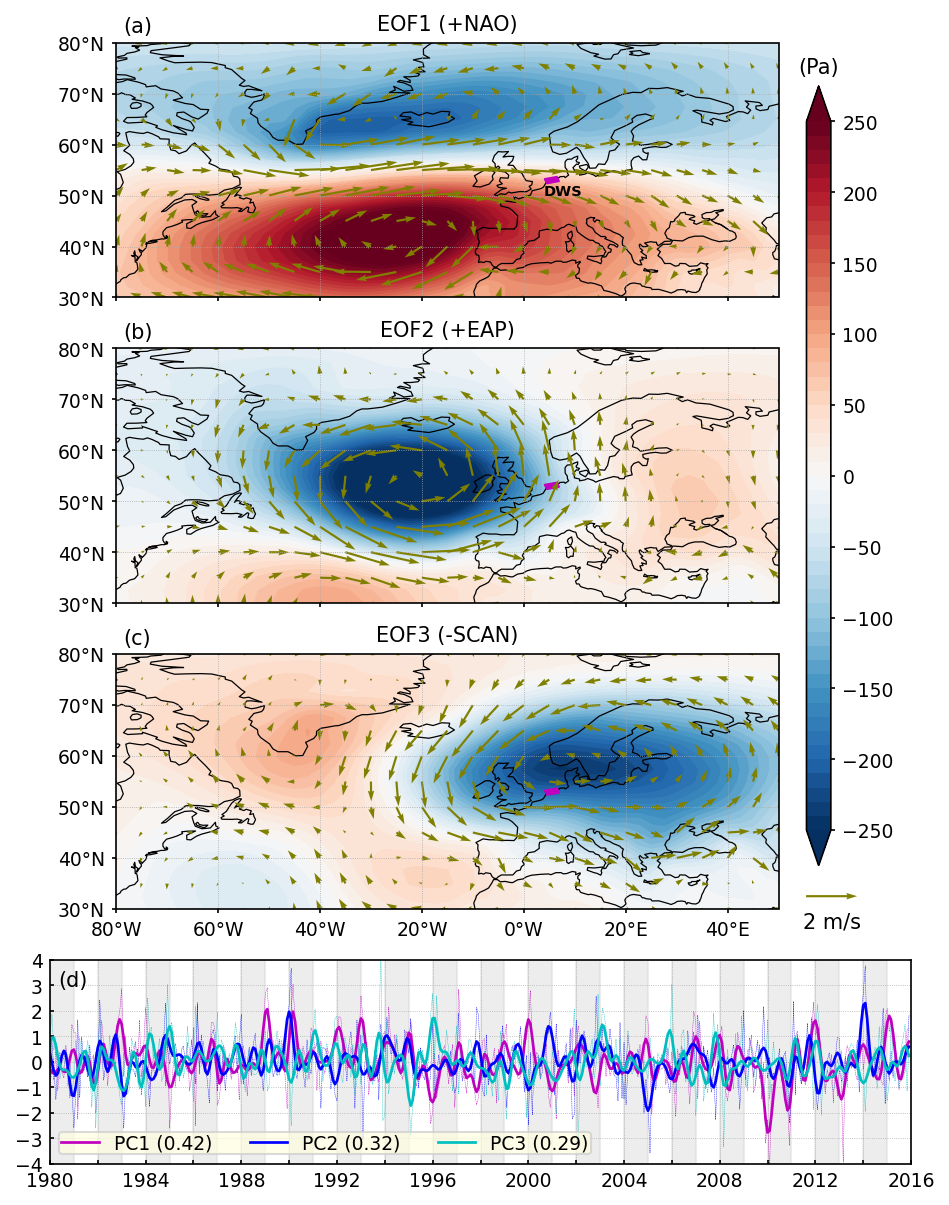

In [15]:
#plot----
#DWS numerical domain (the same as above)
lons = [4.469283, 6.789564, 6.387093, 4.025996]
lats = [52.497467, 52.923164, 53.760746, 53.3269]
ring = LinearRing(list(zip(lons, lats)))
#
labels=['(a)','(b)','(c)']
eof_name=['(+NAO)','(+EAP)','(-SCAN)']
axs=[]
units='height';width=0.0085;scale=10
#
fig,ax = plt.subplots(3,1,figsize=(8,7.5),subplot_kw={'projection':ccrs.PlateCarree()},dpi=150)
for i in range(3):   
    cs=ax[i].contourf(ds.lon,ds.lat,ds.eof.isel(mode=i)*100,levels=np.arange(-250,260,10),cmap="RdBu_r",extend="both",transform=ccrs.PlateCarree(),zorder=0)  # the data's projection
    ax[i].coastlines(lw=.6,color='k',zorder=0,resolution='110m')
    ax[i].add_geometries([ring],ccrs.PlateCarree(),facecolor='m',edgecolor='m',zorder=1)
    Q = ax[i].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],ds.ug_from_eof[i,::iyy,::ixx].values,ds.vg_from_eof[i,::iyy,::ixx].values,units=units,width=width,scale=scale,color='olive',transform=ccrs.PlateCarree(),zorder=2)
    if i==2: qk = ax[i].quiverkey(Q, 1.08, 0.05, 2, '2 m/s', labelpos='S')
    ax[i].set_xticks(np.arange(-80,80,20), crs=ccrs.PlateCarree())
    ax[i].set_yticks(np.arange(30,90,10), crs=ccrs.PlateCarree())
    if i==2: 
        ax[i].xaxis.set_major_formatter(lon_formatter);
    else:
        ax[i].set_xticklabels("");
    if i==0: ax[i].text(lons[0]-.5,lats[0]-2.5,"DWS",fontsize=7,fontweight='bold', transform=ccrs.PlateCarree())
    ax[i].yaxis.set_major_formatter(lat_formatter)
    ax[i].set_extent([-80,50,30,80],ccrs.PlateCarree())
    ax[i].gridlines(draw_labels=False,crs=ccrs.PlateCarree(),linewidth=.4,linestyle=':',color='darkgray')
    ax[i].set_xlabel(""); ax[i].set_ylabel(""); ax[i].set_title(f"EOF{i+1} {eof_name[i]}")
    ax[i].text(0.01,1.04,labels[i],transform=ax[i].transAxes,fontsize=glob_font_size+1)#fontweight='bold'
    axs+=[ax[i]]
    if i==2:
        cbar=fig.colorbar(cs,ax=axs,ticks=np.arange(-250,260,50),aspect=32,pad=0.03,shrink=.9);
        cbar.ax.set_title(label="(Pa)")
    for c in cs.collections: c.set_edgecolor("face") #fix for the white lines between contourf levels
#
#(d)----
ax1=ax[i].inset_axes((-.1,-1,1.3,.8))
xticks_lab=np.arange(1980,int(str(t[-1])[:4])+2,2)
xticks=[np.datetime64(str(i)+'-01-01') for i in xticks_lab]
#plot yearly lines in the background
tt=np.arange(np.datetime64("1980"),np.datetime64("2018"),2)
tt2=np.arange(np.datetime64("1981"),np.datetime64("2017"),2)
for i in range(len(tt)-1): ax1.axvspan(tt[i],tt2[i],alpha=.4,color='lightgrey') 
cols=["m","b","c"]
for i in range(3): 
    if i<2:
        ax1.plot(t,ds.pc.isel(mode=i),c=cols[i],lw=.2,ls='--')
    else:
        ax1.plot(t,ds.pc.isel(mode=i)*-1,c=cols[i],lw=.2,ls='--')
for i in range(3): 
    if i<2:
        ax1.plot(t,pcs_low[i],label=f"PC{i+1} ({var_low[i]:.2f})",c=cols[i],lw=1.3)
    else:
        ax1.plot(t,pcs_low[i]*-1,label=f"PC{i+1} ({var_low[i]:.2f})",c=cols[i],lw=1.3)
ax1.grid(ls=":",lw=.4)
ax1.legend(loc='lower left',ncol=3,framealpha=.7,facecolor='lightyellow',borderpad=0.1);
ax1.set_xlim(np.datetime64("1980"),np.datetime64("2016"));ax1.set_title("");ax1.set_xlabel("");ax1.set_ylabel("");
ax1.set_ylim([-4,4]);ax1.set_yticks(np.arange(-4,5,1))
ax1.set_xticks(xticks); ax1.set_xticklabels(xticks_lab);
ax1.text(0.01,.87,'(d)',transform=ax1.transAxes,fontsize=glob_font_size+1)#fontweight='bold'
for label in ax1.get_xticklabels()[1::2]: label.set_visible(False) #hide every 2 tick label
ax1.tick_params(direction="in");
#
fig_name='f08'
fig.savefig(f'{main_dir}{dir_repo_name}{dir_figures}{agu_number}-{fig_name}.jpg',bbox_inches='tight',pad_inches=0.1,dpi=600)
fig.savefig(f'{main_dir}{dir_repo_name}{dir_figures}{agu_number}-{fig_name}.pdf',bbox_inches='tight',pad_inches=0.1,dpi=600)